# K-Nearest Neighbors 

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

-- Taken from Kaggle.com

In [ ]:
import numpy as np
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_validate
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("breast_cancer.csv")
df.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
df.shape

(699, 11)

In [ ]:
def data_cleaning(data):
  unique_values = []
  na_values = []
  null_values = []
  columns = []

  for column in data.columns.values:
    unique_values.append(len(np.unique(data[column])))
    na_values.append(list(data[column].isna()).count(True))
    null_values.append(list(data[column].isnull()).count(True))
    columns.append(column)

  data_validated = pd.DataFrame(index=columns) 
  data_validated["unique_values"] = list(unique_values)
  data_validated["na_values"] = list(na_values)
  data_validated["null_values"] = list(null_values)
  return data_validated


In [ ]:
data_cleaning(df)

,unique_values,na_values,null_values
id,645,0,0
clump_thickness,10,0,0
size_uniformity,10,0,0
shape_uniformity,10,0,0
marginal_adhesion,10,0,0
epithelial_size,10,0,0
bare_nucleoli,11,0,0
bland_chromatin,10,0,0
normal_nucleoli,10,0,0
mitoses,9,0,0


In [ ]:
column = [df.columns.values[x] for x in range(1,df.shape[1])]
for j in column:
  print(f"{j}, {np.unique(df[j])}")

clump_thickness, [ 1  2  3  4  5  6  7  8  9 10]
size_uniformity, [ 1  2  3  4  5  6  7  8  9 10]
shape_uniformity, [ 1  2  3  4  5  6  7  8  9 10]
marginal_adhesion, [ 1  2  3  4  5  6  7  8  9 10]
epithelial_size, [ 1  2  3  4  5  6  7  8  9 10]
bare_nucleoli, ['1' '10' '2' '3' '4' '5' '6' '7' '8' '9' '?']
bland_chromatin, [ 1  2  3  4  5  6  7  8  9 10]
normal_nucleoli, [ 1  2  3  4  5  6  7  8  9 10]
mitoses, [ 1  2  3  4  5  6  7  8 10]
class, [2 4]


In [ ]:
df.groupby("bare_nucleoli").count()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
bare_nucleoli,,,,,,,,,,
1,402,402,402,402,402,402,402,402,402,402
10,132,132,132,132,132,132,132,132,132,132
2,30,30,30,30,30,30,30,30,30,30
3,28,28,28,28,28,28,28,28,28,28
4,19,19,19,19,19,19,19,19,19,19
5,30,30,30,30,30,30,30,30,30,30
6,4,4,4,4,4,4,4,4,4,4
7,8,8,8,8,8,8,8,8,8,8
8,21,21,21,21,21,21,21,21,21,21


In [ ]:
df[df["bare_nucleoli"]=="?"]

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


Let's delete feature "id". It's not relevant for the **analysis**

In [ ]:
df = df.drop(["id"],1)
df.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


As we are going to use K Nearest Neighbors algorithm, one the actions that we could take to replace "?" value in feature "bare_nucleoli" is to set a really far away value. Another action would be to drop 16 rows where "bare_nucleoli" = "?".

Our dataset is only of 600 samples, so it's not good to reduce it. Therefore, let's replace "?" with the number -99999.

In [ ]:
df = df.replace('?','-99999')

In [ ]:
for column in df.columns.values:
  print(np.unique(df[column]))

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
['-99999' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8 10]
[2 4]


In [ ]:
for i in range(df.shape[0]):
  df["bare_nucleoli"][i]=int(df["bare_nucleoli"][i])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for column in df.columns.values:
  print(np.unique(df[column]))

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[-99999 1 2 3 4 5 6 7 8 9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8 10]
[2 4]


In [ ]:
Y=df["class"]

In [ ]:
X=df[df.columns.values[:9]]

In [ ]:
X.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

### KNN Classifier 

In [ ]:
n_neighbors=[3,5,7,9,12]
for n_neighbor in n_neighbors:
  clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbor)
  model = clf.fit(X_train,Y_train)
  print(n_neighbor,model.score(X_test,Y_test))

3 0.9642857142857143
5 0.9785714285714285
7 0.9857142857142858
9 0.9785714285714285
12 0.9642857142857143


For 5 nearest neighbors classifier (5-NN) maximum precision is reached > 98%

In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
model = clf.fit(X_train,Y_train)

In [ ]:
model.predict(X_test)

array([2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2,
       2, 2, 4, 2, 4, 2, 4, 2, 2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4,
       4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 4,
       2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 4, 4, 2, 2, 4, 2,
       2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 4,
       2, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
np.asarray(Y_test)

array([2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2,
       2, 2, 4, 2, 4, 2, 4, 2, 2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 2, 4, 4, 4,
       4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 4,
       2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 4, 4, 2, 2, 4, 2,
       2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 4, 2, 4, 4,
       2, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
result_data = pd.DataFrame()
result_data["Actual value"]=list(Y_test)
result_data["Predicted value"]=list(model.predict(X_test))
result_data.head(10)

,Actual value,Predicted value
0,2,2
1,2,2
2,2,2
3,4,4
4,4,4
5,4,4
6,4,4
7,2,2
8,2,2
9,2,2


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)

In [ ]:
Xx = X[['clump_thickness','size_uniformity']]

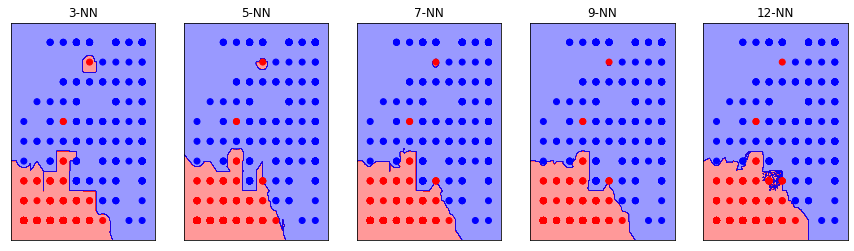

In [ ]:
figure = plt.figure(figsize=(15, 4))
n_neighbours = [3,5,7,9,12]
i = 1
for n in n_neighbours:
    clf = neighbors.KNeighborsClassifier(n, weights='distance')
    clf.fit(Xx, Y)
    ax = plt.subplot(1, len(n_neighbours), i)
    i += 1

    plot_decision_regions(X=Xx.values, y=clf.predict(Xx), classifier=clf)
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(str(n) + '-NN')

plt.show()